# Draft 2: Beginning of Season Hurricane Forecasting
Objective: Predict the number of named storms that will occur in a given season based on prevailing conditions in May of that year (the time of year when many hurricane forecasts are released).

In [58]:
import pandas as pd
import numpy as np
from time import process_time
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn model pipelining and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

# sklearn models
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge

In [3]:
# Read Number of Storms per year data from hurdat
# TS = Tropical Storms, HU = Hurricanes, TOTAL = total named storms
nstorms = pd.read_csv('data/nstorms_byyear.csv').drop(['Unnamed: 0'], axis=1)
nstorms.head()

,year,TS,HU,TOTAL
0,1950,3,11,14
1,1951,3,8,11
2,1952,2,5,7
3,1953,2,7,9
4,1954,3,6,9


In [20]:
buoy_data = pd.read_csv('data/monthly_buoydata.csv').drop(['Unnamed: 0'], axis=1).rename(columns={'YY':'year','MM':'month'})
buoy_data = buoy_data[['station_name','year','month','WDIR','WSPD','WVHT','PRES','ATMP','WTMP']]
buoy_data.head()

,station_name,year,month,WDIR,WSPD,WVHT,PRES,ATMP,WTMP
0,"Corpus Christi, TX",2023,1,147.584567,6.681963,1.498904,1017.714138,19.865897,20.871371
1,"Corpus Christi, TX",2023,2,170.765878,6.780516,1.511411,1021.014190,18.835244,20.997623
2,"Corpus Christi, TX",2023,3,119.578815,6.644980,1.560838,1014.904338,21.121627,21.373889
3,"Corpus Christi, TX",2023,4,112.603981,6.751396,1.506480,1015.142761,23.044101,23.354717
4,"Corpus Christi, TX",2023,5,124.815166,4.960036,0.889086,1014.877589,25.980540,26.215419


In [49]:
stations = buoy_data.station_name.unique()
# Stations with data going back to 1975:
stations_1976 = ['South Hatteras','Mid Gulf']

df_list = []

for station in stations_1975:
    print(station)
    df = buoy_data[buoy_data['station_name'] == station]
    first_year = np.max([np.min(df[['year']]), 1976])
    first_month_of_first_year = np.min(df[df['year'] == first_year]['month'])
    print(str(first_year) + '-' + str(first_month_of_first_year))
    
    # Create a date range from January 1975 OR first month for which data is avialable, to December 2023
    start_date = str(first_year)+'-'+str(first_month_of_first_year).zfill(2)
    date_range = pd.date_range(start=start_date, end='2023-12', freq='MS')
    # Create a dataframe from the date range
    full_date_df = pd.DataFrame({'date': date_range})
    # Extract year and month from the date
    full_date_df['year'] = full_date_df['date'].dt.year
    full_date_df['month'] = full_date_df['date'].dt.month
    # Drop the date column as it's no longer needed
    full_date_df.drop(columns='date', inplace=True)
    #print(full_date_df.head())
    
    merged_df = pd.merge(full_date_df, df, on=['year', 'month'], how='left')
    #print(merged_df[merged_df['year']==1978])
    merged_df = merged_df.ffill().bfill()
    #print(merged_df[merged_df['year']==1978])
    #print(merged_df.head(10))

    # Rename columns not named 'year' or 'month'
    station_nospace = station.replace(" ", "")+"_"
    df2 = merged_df.rename(columns=lambda x: f"{station_nospace}{x}" if x not in ['year', 'month', 'station_name'] else x, inplace=False)
    df2 = df2.drop(['station_name'], axis=1)

    df_list.append(df2)

buoy_data_wide = df_list[0]
# Iterate over the remaining DataFrames and merge them into the wide DataFrame
for df in df_list[1:]:
    buoy_data_wide = pd.merge(buoy_data_wide, df, on=['year', 'month'], how='outer')

buoy_data_may = buoy_data_wide[buoy_data_wide['month']==5].reset_index(drop=True)
print(buoy_data_may.head())

South Hatteras
1976-1
Mid Gulf
1976-1
   year  month  SouthHatteras_WDIR  SouthHatteras_WSPD  SouthHatteras_WVHT  \
0  1976      5          174.836066            7.820902            1.344788   
1  1977      5          191.100402            5.914800            1.046774   
2  1978      5          182.210526            6.320974            1.259184   
3  1979      5          182.451923            6.328415            1.122034   
4  1980      5          190.704301            5.840726            1.271640   

   SouthHatteras_PRES  SouthHatteras_ATMP  SouthHatteras_WTMP  MidGulf_WDIR  \
0         1017.281070           21.195082           22.142798    126.619048   
1         1016.840000           21.525600           23.178313    145.346154   
2         1017.174157           21.523970           23.256180    137.108871   
3         1152.858992           21.932455           22.586250    130.362903   
4         1014.444489           22.034677           23.021909    138.636119   

   MidGulf_WSPD  M

In [139]:
# Ocean Nino Index Data

oni = pd.read_csv('data/Monthly_Nino_3.4_Index.csv')
# Note that we filter to the month of May here:
oni2 = oni[oni['month']==5].drop(['Unnamed: 0','month','ONI_climAdjust'],axis=1).set_index('year')
oni2.head()

,ONI_total,ONI_anom
year,,
1950,26.19,-1.37
1951,27.93,0.37
1952,27.79,0.23
1953,28.28,0.71
1954,27.11,-0.45


In [52]:
df = pd.merge(nstorms[nstorms['year']>= 1976], buoy_data_may, left_on = 'year', right_on = 'year', how = 'inner').set_index('year')
df = df.drop(['month'],axis=1)
df = pd.merge(df, oni2, left_on = 'year', right_on = 'year', how = 'left')
df.head()

,TS,HU,TOTAL,SouthHatteras_WDIR,SouthHatteras_WSPD,SouthHatteras_WVHT,SouthHatteras_PRES,SouthHatteras_ATMP,SouthHatteras_WTMP,MidGulf_WDIR,MidGulf_WSPD,MidGulf_WVHT,MidGulf_PRES,MidGulf_ATMP,MidGulf_WTMP,ONI_total,ONI_anom
year,,,,,,,,,,,,,,,,,
1976,2,6,8,174.836066,7.820902,1.344788,1017.281070,21.195082,22.142798,126.619048,5.714488,0.889695,1043.881690,23.702120,25.060071,27.20,-0.31
1977,1,5,6,191.100402,5.914800,1.046774,1016.840000,21.525600,23.178313,145.346154,4.367308,1.204286,1015.015385,25.011538,25.721154,27.72,0.22
1978,6,5,11,182.210526,6.320974,1.259184,1017.174157,21.523970,23.256180,137.108871,4.766532,1.035593,1013.395181,25.568675,25.269697,27.20,-0.31
1979,3,5,8,182.451923,6.328415,1.122034,1152.858992,21.932455,22.586250,130.362903,6.003629,1.189069,1014.309677,25.319355,25.599588,27.69,0.19
1980,2,9,11,190.704301,5.840726,1.271640,1014.444489,22.034677,23.021909,138.636119,5.668414,0.920699,1012.922849,25.641667,25.988844,28.02,0.51


In [53]:
#unused_cols = ['MWD','DEWP','VIS','TS','HU']
unused_cols = ['TS','HU','ONI_anom']
df_nona = df.drop(unused_cols, axis=1).dropna()
X = df_nona.drop(['TOTAL'], axis=1)
y = df_nona['TOTAL']

X.head()

,SouthHatteras_WDIR,SouthHatteras_WSPD,SouthHatteras_WVHT,SouthHatteras_PRES,SouthHatteras_ATMP,SouthHatteras_WTMP,MidGulf_WDIR,MidGulf_WSPD,MidGulf_WVHT,MidGulf_PRES,MidGulf_ATMP,MidGulf_WTMP,ONI_total
year,,,,,,,,,,,,,
1976,174.836066,7.820902,1.344788,1017.281070,21.195082,22.142798,126.619048,5.714488,0.889695,1043.881690,23.702120,25.060071,27.20
1977,191.100402,5.914800,1.046774,1016.840000,21.525600,23.178313,145.346154,4.367308,1.204286,1015.015385,25.011538,25.721154,27.72
1978,182.210526,6.320974,1.259184,1017.174157,21.523970,23.256180,137.108871,4.766532,1.035593,1013.395181,25.568675,25.269697,27.20
1979,182.451923,6.328415,1.122034,1152.858992,21.932455,22.586250,130.362903,6.003629,1.189069,1014.309677,25.319355,25.599588,27.69
1980,190.704301,5.840726,1.271640,1014.444489,22.034677,23.021909,138.636119,5.668414,0.920699,1012.922849,25.641667,25.988844,28.02


## Initial Modeling, using default hyperparameters, training on ALL data

In [141]:
lr = LinearRegression().fit(X, y)
preds = lr.predict(X)

pipe_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso())
])
pipe_lasso.fit(X,y)
preds_lasso = pipe_lasso.predict(X)

pipe_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])
pipe_ridge.fit(X,y)
preds_ridge = pipe_ridge.predict(X)

In [142]:
y_preds = df_nona[['TOTAL']].copy().reset_index().rename(columns = {'TOTAL':'actual'})
baseline = np.mean(y_preds['actual'])
y_preds['baseline'] = baseline
y_preds['predicted'] = preds
y_preds['lasso'] = preds_lasso
y_preds['ridge'] = preds_ridge
y_preds.head()

,year,actual,baseline,predicted,lasso,ridge
0,1976,8,12.638298,9.762552,11.373939,9.886046
1,1977,6,12.638298,14.184786,12.720916,14.117126
2,1978,11,12.638298,13.997355,12.721585,13.917756
3,1979,8,12.638298,11.486973,12.674738,11.578215
4,1980,11,12.638298,11.087828,12.317004,11.164889


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

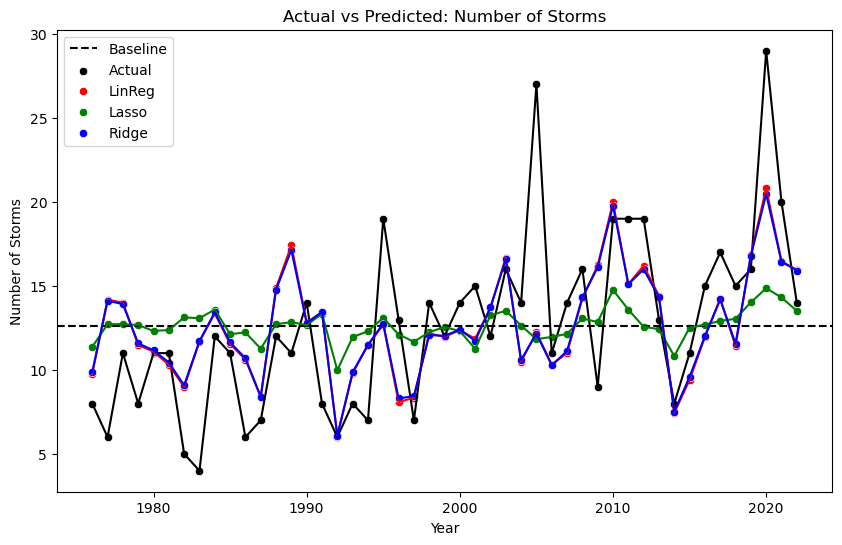

In [144]:
plt.figure(figsize=(10, 6))
plt.axhline(y=baseline, color='black', linestyle='--', label='Baseline')

# Plot the actual values
sns.scatterplot(data=y_preds, x='year', y='actual', color='black', label='Actual')
sns.lineplot(data=y_preds, x='year', y='actual', color='black')

# Plot the predicted values
sns.scatterplot(data=y_preds, x='year', y='predicted', color='red', label='LinReg')
sns.lineplot(data=y_preds, x='year', y='predicted', color='red')

# Plot the predicted values - Lasso
sns.scatterplot(data=y_preds, x='year', y='lasso', color='green', label='Lasso')
sns.lineplot(data=y_preds, x='year', y='lasso', color='green')

# Plot the predicted values - Ridge
sns.scatterplot(data=y_preds, x='year', y='ridge', color='blue', label='Ridge')
sns.lineplot(data=y_preds, x='year', y='ridge', color='blue')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Number of Storms')
plt.title('Actual vs Predicted: Number of Storms')
plt.legend()

# Display the plot
plt.show()

Note: I expect that these (particularly the LinReg and barely-regularized Ridge analysis) are way overfit and would not do well on new data. This is a major challenge for this problem -- given the limited number of samples due to good data only going back 50 or so years, it may be difficult to create a predictive model that doesn't overfit.

#### Mean Squared Error

In [60]:
mse_baseline = mean_squared_error(y_preds['actual'],y_preds['baseline'])
print(mse_baseline)

27.08193752829335


In [61]:
mse_lr = mean_squared_error(y_preds['actual'],y_preds['predicted'])
print(mse_lr)

17.402184234981736


In [62]:
mse_lasso = mean_squared_error(y_preds['actual'],y_preds['lasso'])
print(mse_lasso)

23.291898106767103


# Same models with GridSearchCV and a Test/Train split:
- Train Test split with data before 2009 as train data, 2009 on used as test data
- Scaling with StandardScaler()
- Grid search for best hyperparameters for Lasso and Ridge (alpha term that controls amount of regularization)

Introduce a new "y" to train on: *Accumulated Cyclone Energy (ACE)*, which accounts for storm duration and strength (stronger, longer duration storms count more toward ACE). In some ways ACE is a better measure of hurricane activity, and perhaps it will be easier to predict than the simple storm count.

In [ ]:
ace0 = pd.read_csv('data/ace-north-atlantic-hurricanes.csv')
ace = ace0[['Year','Acumulated cyclone energy index']].rename(columns={'Acumulated cyclone energy index':'ACE','Year':'year'}).set_index('year')
ace.head()
y_wACE = pd.merge(y, ace, on='year')
y_wACE

In [79]:
train_test_year_split = 2008
X_train = X[X.index <= train_test_year_split]
X_test = X[X.index > train_test_year_split]
y_train = y[y.index <= train_test_year_split]
y_test = y[y.index > train_test_year_split]

In [128]:
def run_grid(model_setup, ACE = False, N_JOBS = 1, N_CV = 5):
    start = process_time()
    
    # Make Pipeline
    pipe = Pipeline([
        #('preprocessor',preprocessor),
        ('poly', PolynomialFeatures(degree = 3)),
        ('scaler',StandardScaler()),
        (model_setup.get('name'), model_setup.get('model'))
        ])

    # Fit Grid on all params
    grid = GridSearchCV(estimator = pipe,
                        param_grid = model_setup.get('param_dict'),
                       cv = N_CV,
                       n_jobs = N_JOBS)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_train_preds = best_model.predict(X_train)
    y_test_preds = best_model.predict(X_test)

    # Save stuff to a dataframe (best params, fit time, scores)
    res_dict = {'model': [model_setup.get('name')],
                'best_params': [grid.best_params_],
                'best_score': [grid.best_score_],
                'fit time': [grid.refit_time_],
               'train r2': [grid.score(X_train, y_train)],
               'test r2': [grid.score(X_test, y_test)],
                'train mse': [mean_squared_error(y_train, y_train_preds)],
                'test mse': [mean_squared_error(y_test, y_test_preds)]
               }
    res_df = pd.DataFrame(res_dict)

    feature_names = best_model.named_steps['poly'].get_feature_names_out()
    coefs = best_model.named_steps[model_setup.get('name')].coef_
    coef_df = pd.DataFrame({'feature':feature_names, 'coef':coefs})

    end = process_time()
    print('total time to run: ',end - start)
    
    return(res_df, best_model, coef_df)

In [135]:
model_setup_linreg = {
    'name':'linreg',
    'param_dict':{'poly__degree':[1,2,3,4,5,6]},
    'model': LinearRegression()
}
results_linreg, best_linreg, _ = run_grid(model_setup_linreg, N_JOBS = 2)
results_linreg

total time to run:  0.04631700000000194


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,linreg,{'poly__degree': 1},-8.578495,0.00421,0.337943,-2.145051,13.672792,82.220609


In [136]:
model_setup_lasso = {
    'name':'lasso',
    'param_dict':{'lasso__alpha':[0.01,0.1,1,2.5,5,8,10,20,50,100],
                  'lasso__max_iter':[1000000],
                  'lasso__random_state':[42],
                 'poly__degree':[1,2,3,4,5,6]},
    'model': Lasso()
}
results_lasso, best_lasso, coefs_lasso = run_grid(model_setup_lasso, N_JOBS = 2)
results_lasso

total time to run:  0.15320900000000393


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,lasso,"{'lasso__alpha': 1, 'lasso__max_iter': 1000000...",-0.83908,0.002414,0.116977,-0.844146,18.236161,48.211233


In [137]:
model_setup_ridge = {
    'name':'ridge',
    'param_dict':{'poly__degree':[1,2,3,4,5,6],
                  'ridge__random_state':[42],
                  'ridge__alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000,2000,2500,3000,5000,7500,10000]},
    'model': Ridge()
}
results_ridge, best_ridge, coefs_ridge = run_grid(model_setup_ridge, N_JOBS = 2)
results_ridge

total time to run:  0.3794459999999873


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,ridge,"{'poly__degree': 3, 'ridge__alpha': 2500, 'rid...",-0.720753,0.031077,0.185689,-0.956752,16.817133,51.155093


   year  actual   baseline     linreg      lasso      ridge
0  1976       8  12.638298  12.596449  11.207736  11.121372
1  1977       6  12.638298   8.744197  10.865202  10.567006
2  1978      11  12.638298  10.029162  10.821566  10.832562
3  1979       8  12.638298  10.161174  10.954926  10.751921
4  1980      11  12.638298  13.569141  11.062741  11.218358


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

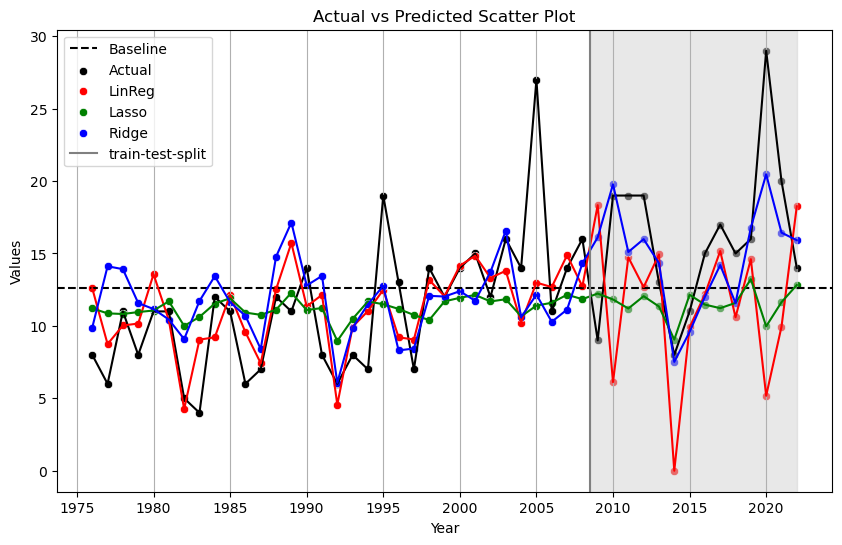

In [138]:
#for model in [best_linreg, best_lasso, best_ridge]:
#    model_name = list(model.named_steps.keys())[2]
#    preds = model.predict(X)

preds_linreg = best_linreg.predict(X)
preds_ridge = best_ridge.predict(X)
preds_lasso = best_lasso.predict(X)

y_preds_gridsearch = pd.DataFrame(y).rename(columns={'TOTAL':'actual'})
baseline = np.mean(y_preds_gridsearch['actual'])
y_preds_gridsearch['baseline'] = baseline
y_preds_gridsearch['linreg'] = preds_linreg
y_preds_gridsearch['lasso'] = preds_lasso
y_preds_gridsearch['ridge'] = preds_ridge
y_preds_gridsearch.reset_index(inplace=True)
y_preds_gridsearch = y_preds_gridsearch.clip(lower=0)
print(y_preds_gridsearch.head())

plt.figure(figsize=(10, 6))
plt.axhline(y=baseline, color='black', linestyle='--', label='Baseline')

# Plot the actual values
sns.scatterplot(data=y_preds_gridsearch, x='year', y='actual', color='black', label='Actual')
sns.lineplot(data=y_preds_gridsearch, x='year', y='actual', color='black')

# Plot the predicted values
sns.scatterplot(data=y_preds_gridsearch, x='year', y='linreg', color='red', label='LinReg')
sns.lineplot(data=y_preds_gridsearch, x='year', y='linreg', color='red')

# Plot the predicted values - Lasso
sns.scatterplot(data=y_preds_gridsearch, x='year', y='lasso', color='green', label='Lasso')
sns.lineplot(data=y_preds_gridsearch, x='year', y='lasso', color='green')

# Plot the predicted values - Ridge
sns.scatterplot(data=y_preds, x='year', y='ridge', color='blue', label='Ridge')
sns.lineplot(data=y_preds, x='year', y='ridge', color='blue')

plt.axvline(x=2008.5, color='gray', linestyle='-', label='train-test-split')
plt.axvspan(2008.5, np.max(y_preds_gridsearch['year'].astype(int)), color='lightgray', alpha=0.5)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Values')
plt.title('Actual vs Predicted: Number of Storms')
plt.legend()

# Customize the ticks and gridlines
from matplotlib.ticker import MultipleLocator
plt.gca().xaxis.set_major_locator(MultipleLocator(5))  # Set the ticks every 5 years
plt.grid(True, which='both', axis='x')  # Ensure gridlines are visible

# Display the plot
plt.show()

# Results
Take a look at the test r2 for lasso and ridge regression above. We have no confidence that this model is working correctly (r^2 < 0!!).

Because of this outcome, I've decided to do a different type of forecast: using monthly atmospheric/climatological data to forecast number of storms in that month. This effectively 12x the available data since we can use monthly rather than only May data.